In [1]:
import librosa as librosa
import librosa.display
import IPython.display as ipd
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import classification_report
import librosa
from sklearn.svm import SVC 
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix


In [230]:

header = 'filename rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'

for i in range(1, 40):
    header += f' mfcc{i}'
header = header.split()
# print('CSV Header: ', header)
file = open("data.csv", 'w', newline='')
writer = csv.writer(file)
writer.writerow(header)
file.close()


def writeCsv(data):
    file = open("data.csv", 'a', newline='')
    writer = csv.writer(file)
    writer.writerow(data.split(","))
    file.close()



def feature_extraction(file_path):
    # iterate through all file
        y, sr = librosa.load(file_path, mono=True, duration=30)
            # remove leading and trailing silence
        y, index = librosa.effects.trim(y)
        # chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        rmse = librosa.feature.rms(y=y)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr,n_mfcc=39)
        to_append = f'{file},{np.mean(rmse)},{np.mean(spec_cent)},{np.mean(spec_bw)},{np.mean(rolloff)},{np.mean(zcr)}'
        for e in mfcc:
            to_append += f',{np.mean(e)}'
        
        writeCsv(to_append)
        return to_append

to_append =[]





path ='./Data/Person_data/'

for file in os.listdir(path):
    # print(file)
    file_path = f"{path}\{file}"  
    data = feature_extraction(file_path)








    

In [242]:
def feature_extraction_array(file_path):
    to_append =[]
    # iterate through all file
    y, sr = librosa.load(file_path, mono=True, duration=30)
        # remove leading and trailing silence
    y, index = librosa.effects.trim(y)
    # chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    rmse = librosa.feature.rms(y=y)
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)
    mfcc = librosa.feature.mfcc(y=y, sr=sr,n_mfcc=39, n_fft=1024, hop_length=512)
    to_append.append(np.mean(rmse))
    to_append.append(np.mean(spec_cent))
    to_append.append(np.mean(spec_bw))
    to_append.append(np.mean(rolloff))
    to_append.append(np.mean(zcr))
    for e in mfcc:
        to_append.append(np.mean(e))
    return to_append
    
    
def preProcessing(csvName):
    data = pd.read_csv(csvName)
    audioName = data['filename']
    speakerNumber = []
    for i in range(len(audioName)):
        speakerLetter = audioName[i][0]
        if speakerLetter == "A":
            speakerLetter = 0
        elif speakerLetter =="H":
            speakerLetter=1
        elif speakerLetter == "M":
            speakerLetter = 2
        elif speakerLetter =="Y":
            speakerLetter = 3
        else:
            speakerLetter = 4
        speakerNumber.append(speakerLetter)

    data = data.drop(['filename'],axis=1)


    print(data.tail())
    
    return data, speakerNumber


***Speaker Recognition***

In [243]:
data, number = preProcessing("data.csv")


         rmse  spectral_centroid  spectral_bandwidth      rolloff  \
107  0.036961         900.262590         1228.633450  1710.715110   
108  0.030798        1110.509419         1415.479838  2223.205344   
109  0.043172        1029.468179         1322.851465  1998.239840   
110  0.039588        1086.552395         1351.697446  2114.756303   
111  0.029859         916.739124         1247.753847  1742.170715   

     zero_crossing_rate       mfcc1       mfcc2      mfcc3      mfcc4  \
107            0.035929 -384.608643  144.547806   8.870942  20.455149   
108            0.047576 -377.867615  147.641052  12.861173  29.303251   
109            0.039006 -368.788727  147.944244   3.276975  19.193602   
110            0.046777 -375.518097  142.554230   7.776324  18.943033   
111            0.038239 -399.210754  149.685547  15.412180  12.311265   

         mfcc5  ...    mfcc30    mfcc31    mfcc32    mfcc33    mfcc34  \
107  17.201056  ... -5.936404 -3.372059 -6.162612 -3.362956 -1.793169   


In [244]:
X= np.array(data)

y=np.asarray(number)

In [245]:
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=123
    )


In [261]:
svm_model= svm.SVC(kernel='linear' , C=0.002)
svm_model.fit(X_train, y_train) 

y_pred = svm_model.predict(X_test)



In [263]:
testing = feature_extraction_array('./records/A_Open (7).wav')
y_predict = svm_model.predict([testing])



print(y_predict)


[2]


In [264]:
from sklearn import metrics
y_pred_t = svm_model.predict(X_train)
accuracy_t = metrics.accuracy_score(y_train,y_pred_t)


print(f"  Train model accuracy = {100* accuracy_t:.3} %")
accuracy = metrics.accuracy_score(y_test,y_pred)


print(f"  Test model accuracy = {100* accuracy:.3} %")


  Train model accuracy = 1e+02 %
  Test model accuracy = 91.3 %


***Plot  SVM***

In [106]:
import matplotlib.pyplot as plt

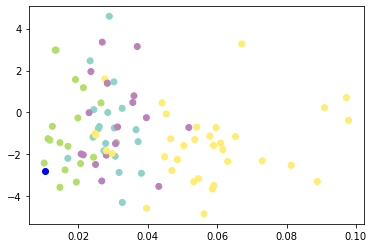

In [265]:
vector = np.vectorize(np.int_)
plt.scatter(X_train[:,0],X_train[:,43],c=vector(y_pred_t), cmap='Set3')
plt.scatter(testing[0],testing[43],c='b', cmap='Set3')

***Spoken Digit Recognition***

In [133]:
""""loop that clac all differnces between each item in array with the other"""
def distance(array):    
    dist = []
    for i in range(len(array)):
        for j in range(len(array)):
            dist.append(np.linalg.norm(array[i]-array[j]))
    return dist 

In [136]:
dist = distance(vector(y_train))